<a href="https://colab.research.google.com/github/lenessvi/zadaniya-/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_6_(%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 6. Обучение без учителя

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Цель занятия:**
Изучить методы обучения без учителя, познакомиться с алгоритмами кластеризации, понять их применение и реализовать модели кластеризации с использованием различных алгоритмов.

## **Задание состоит из следующих частей:**
1. Определение обучения без учителя
2. Разбор алгоритмов DBSSCAN, K-means
3. Метрики качества кластеризации
4. Пример полезных задач, которые решает кластеризация

**P.S.** Некоторые вещи (например PCA, обработка текстовых данных) мы пройдем чуть позже.

## Задачи для домашки ⏰

1. Преобразовать датасет
2. Построить кластеры
3. Описать результат полученных кластеров (для K-Means и DBSSCAN)
4. Объяснить метрики качества

**По желанию**

1. Спарсить данные по статьям (например lenta.ru или naked-science.ru)
2. Преобразовать текста статьи (по принципу описанному в последнем пункте)
3. Оценить метрики качества, провести аналитику кластеров (можно не максимально подробно, если получилось слишком много кластеров)

## Предобработка (все по классике)

Открываем датасет, преобразуем данные, идем дальше

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/employee.csv')

In [ ]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left
0,0.38,0.53,2,157,3,0,0,1
1,0.80,0.86,5,262,6,0,0,1
2,0.11,0.88,7,272,4,0,0,1
3,0.72,0.87,5,223,5,0,0,1
4,0.37,0.52,2,159,3,0,0,1
...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,0,1
14995,0.37,0.48,2,160,3,0,0,1
14996,0.37,0.53,2,143,3,0,0,1
14997,0.11,0.96,6,280,4,0,0,1


### Преобразование категориальных фич

In [ ]:
# Удаляем эти колонки
df = df.drop(columns='department')
df = df.drop(columns='salary')


### Преобразование непрерывных фич

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Выбираем числовые признаки
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
df[numeric_features] = scaler.fit_transform(df[numeric_features])


In [ ]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left
0,0.318681,0.265625,0.0,0.285047,0.125,0.0,0.0,1.0
1,0.780220,0.781250,0.6,0.775701,0.500,0.0,0.0,1.0
2,0.021978,0.812500,1.0,0.822430,0.250,0.0,0.0,1.0
3,0.692308,0.796875,0.6,0.593458,0.375,0.0,0.0,1.0
4,0.307692,0.250000,0.0,0.294393,0.125,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
14994,0.340659,0.328125,0.0,0.257009,0.125,0.0,0.0,1.0
14995,0.307692,0.187500,0.0,0.299065,0.125,0.0,0.0,1.0
14996,0.307692,0.265625,0.0,0.219626,0.125,0.0,0.0,1.0
14997,0.021978,0.937500,0.8,0.859813,0.250,0.0,0.0,1.0


## О кластеризации и задачи обучения без учителя

#### Обучение с учителем

Представьте, что у вас есть список задач с правильными ответами. Например, вам дали примеры: «Это яблоко», «Это груша».

Задача — научиться отличать их, чтобы потом, когда вы увидите новый фрукт, вы смогли правильно его назвать. То есть у вас есть **учитель** — тот, кто заранее всё объяснил и дал правильные ответы.  

#### Обучение без учителя

А теперь представьте, что вам дали корзину фруктов, но никто не сказал, как они называются.

Задача — посмотреть на фрукты и найти, что у них общего, например: круглые положить в одну группу, длинные в другую. Тут вы работаете **без подсказок** и сами решаете, как группировать.  

#### Разница

- В задачах с учителем есть правильные ответы, и мы обучем алгоритм делать предсказания на основе примеров.  
- В задачах без учителя правильных ответов нет, ищем закономерности и пытаемся найти смысл группировки данные самостоятельно.

Пример:


1. **С учителем**: Мы ищем лучшее вино.  
2. **Без учителя**: Мы пытаемся объеденить вина, чтобы понять по какому принципу они объеденяются.  

## K-means

**K-means** — это алгоритм кластеризации, который делит данные на 𝑘 групп (кластеров). Основная идея: найти центры кластеров так, чтобы точки внутри одного кластера были ближе друг к другу, чем к точкам из других кластеров.

1. Инициализация: выбираем 𝑘 случайных центров (центроидов).
2. Присвоение точек: каждая точка относится к ближайшему центру.
Обновление центров: пересчитываем центры кластеров как среднее всех точек в кластере.
3. Повторяем шаги 2–3, пока центры не перестанут меняться или не достигнем максимального числа итераций.

In [ ]:
! pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_kmeans_visualization(X, max_clusters=10, max_iterations=50):

    # преобразуем X в numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_kmeans_iteration(X, centroids, labels=None, step=0):
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        if labels is not None:
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
        else:
            plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.6)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.title(f'K-means Iteration {step}')
        plt.legend()
        plt.show()

    def k_means_interactive(X, k, max_iters):
        np.random.seed(42)
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]
        for step in range(max_iters):
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            plot_kmeans_iteration(X, centroids, labels, step)
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
            if np.all(centroids == new_centroids):
                break
            centroids = new_centroids

    def run_kmeans(k, max_iters):
        k_means_interactive(X, k, max_iters)

    k_slider = widgets.IntSlider(value=3, min=2, max=max_clusters, step=1, description='Clusters (k):')
    iter_slider = widgets.IntSlider(value=10, min=1, max=max_iterations, step=1, description='Max Iterations:')

    interactive_plot = widgets.interactive(run_kmeans, k=k_slider, max_iters=iter_slider)
    display(interactive_plot)

# Берем датасет и визуализируем K-means
interactive_kmeans_visualization(df[:100])


interactive(children=(IntSlider(value=3, description='Clusters (k):', max=10, min=2), IntSlider(value=10, desc…

### K-means через реализацию skelarn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Определяем количество кластеров k
k = 3  # Вы можете изменить это значение в соответствии с вашими данными

# Создаем и обучаем модель KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_

# Добавляем метки кластеров в исходный DataFrame
df_k_means = df.copy()
df_k_means['Cluster'] = labels

# Вывод статистики по кластерам для каждого признака
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_k_means.groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if k > 1:
    silhouette_avg = silhouette_score(df, labels)
    print(f"\nКоэффициент силуэта для k={k}: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен для k=1")


Статистика по кластерам:

Статистика для признака 'satisfaction_level':
             mean       std       min       max
Cluster                                        
0        0.633857  0.238576  0.032967  1.000000
1        0.357170  0.077927  0.010989  0.879121
2        0.407914  0.385580  0.000000  0.912088

Статистика для признака 'last_evaluation':
             mean       std       min  max
Cluster                                   
0        0.555427  0.253133  0.000000  1.0
1        0.251101  0.098503  0.140625  1.0
2        0.819164  0.141468  0.140625  1.0

Статистика для признака 'number_project':
             mean       std  min  max
Cluster                              
0        0.357333  0.195977  0.0  0.8
1        0.015564  0.078477  0.0  0.8
2        0.670346  0.205804  0.0  1.0

Статистика для признака 'average_montly_hours':
             mean       std       min       max
Cluster                                        
0        0.481590  0.213471  0.000000  0.892523
1  

#### **Анализ кластеров**

Статистика по кластерам и коэффициент силуэта дают нам представление о характеристиках групп в задаче кластеризации. Вот краткий анализ:

### 1. **Признак 'satisfaction_level':**
   - **Кластер 0:** Высокий средний уровень удовлетворенности (0.63), с относительно большой вариативностью (стандартное отклонение 0.24). Минимальное значение — 0.03, максимальное — 1.
   - **Кластер 1:** Средний уровень удовлетворенности низкий (0.36), с меньшей вариативностью (стандартное отклонение 0.08). Значения варьируются от 0.01 до 0.88.
   - **Кластер 2:** Средний уровень удовлетворенности (0.41), с большей вариативностью (стандартное отклонение 0.39), что может свидетельствовать о разнородности внутри этого кластера.

### 2. **Признак 'last_evaluation':**
   - **Кластер 0:** Средний уровень последней оценки — 0.56, с высокой вариативностью (стандартное отклонение 0.25).
   - **Кластер 1:** Низкое значение (0.25), и небольшая вариативность (0.10), что может говорить о большей стабильности и меньшем разбросе оценок.
   - **Кластер 2:** Высокий средний уровень последней оценки (0.82), с меньшей вариативностью (0.14), что может говорить о более высоком уровне оценок и меньшем разбросе среди работников этого кластера.

### 3. **Признак 'number_project':**
   - **Кластер 0:** Работники этого кластера участвуют в среднем в 0.36 проектах, с вариативностью 0.20.
   - **Кластер 1:** Значение минимально (0.02), что может свидетельствовать о небольшом числе проектов у работников этого кластера.
   - **Кластер 2:** Работники участвуют в 0.67 проектах в среднем, что значительно выше, чем в кластере 1.

### 4. **Признак 'average_montly_hours':**
   - **Кластер 0:** Среднее количество рабочих часов — 0.48, с достаточно большой вариативностью (стандартное отклонение 0.21).
   - **Кластер 1:** Работники этого кластера проводят в месяц в среднем 0.24 часов, что значительно ниже, с меньшей вариативностью.
   - **Кластер 2:** Высокие значения рабочего времени (0.76), что также сопровождается небольшой вариативностью (стандартное отклонение 0.14).

### 5. **Признак 'time_spend_company':**
   - **Кластер 0:** Среднее значение — 0.17, что может означать, что большинство работников в этом кластере работают в компании относительно недавно.
   - **Кластер 1:** Работники проводят в компании меньше времени (0.13).
   - **Кластер 2:** Работники этого кластера в среднем проводят больше времени в компании (0.32).

### 6. **Признак 'Work_accident':**
   - **Кластер 0:** Работники этого кластера имеют наибольшую вероятность работы с травмами (0.18).
   - **Кластер 1 и 2:** Низкий процент работников, связанных с несчастными случаями (0.05 и 0.05 соответственно).

### 7. **Признак 'promotion_last_5years':**
   - **Кластер 0:** Низкий процент работников, получивших повышение (0.03).
   - **Кластер 1:** Также низкий процент (0.01), что может указывать на ограниченные возможности для карьерного роста в этом кластере.
   - **Кластер 2:** Еще более низкий показатель (0.002), что также может свидетельствовать о меньших возможностях для продвижения.

### 8. **Признак 'left':**
   - **Кластер 0:** Все работники остались в компании (значение 0).
   - **Кластер 1 и 2:** Все работники покинули компанию (значение 1).

### Коэффициент силуэта (Silhouette Score): 0.4143
   - Значение коэффициента силуэта находится в среднем диапазоне (0.41), что говорит о довольно хорошей, но не идеальной кластеризации. Это указывает на то, что кластеры имеют некоторое разделение, но возможны улучшения.

### Итог:
- Кластеризация выявила три кластера с различиями по ключевым признакам, особенно по признаку «left», что подтверждает, что один кластер состоит только из сотрудников, которые остались, а два других — из тех, кто ушел.
- Коэффициент силуэта указывает на среднее качество кластеризации, что предполагает, что можно улучшить разделение кластеров для лучшей четкости.


### DBSSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — это алгоритм кластеризации, основанный на плотности точек в пространстве.

Параметры алгоритма:

- **Epsilon (eps)**: радиус окрестности точки.
- **Min_samples**: минимальное количество точек в eps-окрестности для того, чтобы точка считалась ядром кластера.

Классификация точек:

- **Core point (ядро)**: если в eps-окрестности точки находится не менее min_samples точек, то она является ядром.
- **Border point (граничная точка)**: точка, которая находится в eps-окрестности ядра, но сама не является ядром.
- **Noise point (шум)**: точка, которая не является ни ядром, ни граничной точкой. (**входит в кластер -1**)

Точки, которые связаны по плотности (через ядра и их eps-окрестности), объединяются в один кластер.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def interactive_dbscan_visualization(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric):
        clear_output(wait=True)
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        plt.figure(figsize=(8, 6))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Черный цвет для шума
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
        plt.show()

    def run_dbscan(eps, min_samples, metric):
        # Обучение DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        db.fit(X)
        labels = db.labels_
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric)

    # Виджеты для настройки параметров
    eps_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.05, description='eps:')
    min_samples_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='min_samples:')
    metric_dropdown = widgets.Dropdown(options=['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                                       value='euclidean', description='metric:')

    ui = widgets.VBox([eps_slider, min_samples_slider, metric_dropdown])
    out = widgets.interactive_output(run_dbscan, {'eps': eps_slider, 'min_samples': min_samples_slider, 'metric': metric_dropdown})
    display(ui, out)

# Пример использования
interactive_dbscan_visualization(df[:120])


Output()

### DBSSCAN через sklearn

Количество кластеров: 7
Статистика по кластерам:

Статистика для признака 'satisfaction_level':
             mean       std       min       max  count
Cluster                                               
0        0.384369  0.289750  0.000000  0.912088   3387
1        0.389477  0.302110  0.000000  0.912088    165
2        0.367521  0.024640  0.351648  0.406593      9
3        0.634118  0.238334  0.032967  1.000000   9200
4        0.632330  0.241651  0.032967  1.000000   1928
5        0.642468  0.225644  0.065934  1.000000    226
6        0.666785  0.169528  0.428571  1.000000     62

Статистика для признака 'last_evaluation':
             mean       std       min     max  count
Cluster                                             
0        0.560659  0.309005  0.140625  1.0000   3387
1        0.560133  0.307368  0.140625  1.0000    165
2        0.220486  0.083941  0.140625  0.3125      9
3        0.556479  0.252735  0.000000  1.0000   9200
4        0.550895  0.253552  0.000000  1.0000  

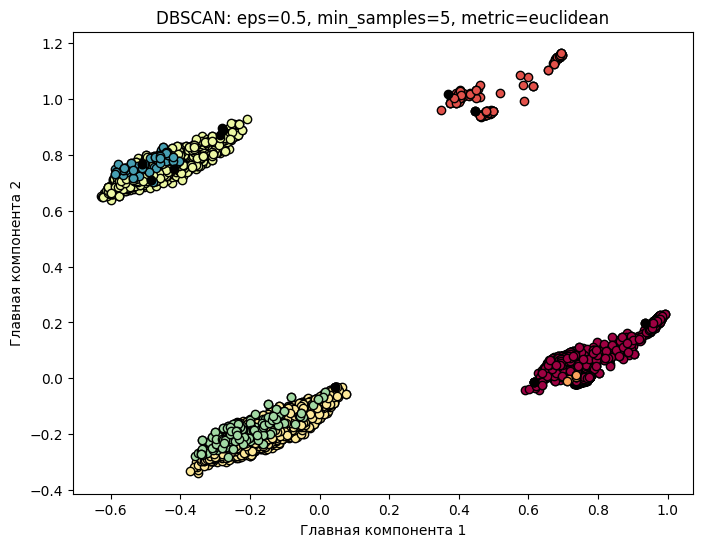

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Параметры DBSCAN
eps = 0.5
min_samples = 5
metric = 'euclidean'

# Обучение модели DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
labels = db.fit_predict(df)

# Добавляем метки кластеров в DataFrame
df_dbscan = df.copy()
df_dbscan['Cluster'] = labels

# Количество кластеров (исключая шум)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Количество кластеров: {n_clusters_}")

# Вывод статистики по кластерам
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_dbscan[df_dbscan['Cluster'] != -1].groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max', 'count'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(df[df_dbscan['Cluster'] != -1], labels[df_dbscan['Cluster'] != -1])
    print(f"\nКоэффициент силуэта для DBSCAN: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен, так как найден один кластер или данные являются шумом.")


# Визуализация результатов (с использованием PCA для снижения размерности)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        # Черный цвет для шума
        col = [0, 0, 0, 1]
    plt.plot(df_pca.loc[class_member_mask, 'PC1'],
             df_pca.loc[class_member_mask, 'PC2'],
             'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()


#### **Анализ кластеров**

### Анализ кластеров (7 кластеров):

#### 1. **Признак 'satisfaction_level':**
   - **Кластеры 0, 1, 2:** Средний уровень удовлетворенности варьируется от 0.37 до 0.39, с вариативностью 0.02 - 0.3. Это указывает на низкий и схожий уровень удовлетворенности в этих кластерах.
   - **Кластеры 3, 4, 5, 6:** Средний уровень удовлетворенности в этих кластерах выше, достигая 0.63 - 0.67, с небольшой вариативностью (стандартное отклонение около 0.2). Эти кластеры характеризуются высокими уровнями удовлетворенности.
   - **Кластеры с наименьшим числом объектов (например, 2)** имеют крайне малое количество записей (9), что может влиять на обобщенность статистики.

#### 2. **Признак 'last_evaluation':**
   - **Кластеры 0, 1:** Средняя оценка близка к 0.56, что указывает на относительно высокие оценки в этих группах, с небольшими различиями в стандартном отклонении.
   - **Кластер 2:** Значение резко ниже (0.22), что говорит о значительных различиях в оценке в сравнении с остальными кластерами.
   - **Кластеры 3, 4, 5:** Средние значения (0.55 - 0.56), с небольшой вариативностью, что отражает сходство этих групп.
   - **Кластер 6:** Более высокое среднее значение (0.59) с большой вариативностью (0.32), что указывает на значительные различия среди работников в этом кластере.

#### 3. **Признак 'number_project':**
   - **Кластеры 0, 1, 3, 4, 5, 6:** В этих кластерах большинство работников участвуют в среднем в 0.36 - 0.37 проектах, с относительно небольшим стандартным отклонением.
   - **Кластер 2:** Все работники в этом кластере не участвуют в проектах (0), что делает его уникальным в этом отношении.

#### 4. **Признак 'average_montly_hours':**
   - **Кластеры 0, 1:** Работники этих кластеров в среднем работают 0.51 - 0.52, что говорит о средней рабочей нагрузке.
   - **Кластер 2:** Рабочие часы заметно ниже (0.25), что может указывать на менее интенсивную работу.
   - **Кластеры 3, 4, 5:** Эти кластеры характеризуются рабочими часами от 0.46 до 0.48, с небольшой вариативностью.
   - **Кластер 6:** Рабочие часы здесь выше (0.58), что может указывать на более интенсивную работу.

#### 5. **Признак 'time_spend_company':**
   - **Кластеры 0, 1:** В этих кластерах средний срок работы в компании — около 0.23 - 0.24 года, что указывает на относительно недавних работников.
   - **Кластер 2:** Работники проводят всего 0.13 года в компании, что указывает на краткосрочную занятость.
   - **Кластеры 3, 4, 5, 6:** Работники проводят в компании от 0.17 до 0.28 года, что указывает на более разнообразный опыт работы среди этих групп.

#### 6. **Признак 'Work_accident':**
   - **Кластеры 0, 3, 5:** Работники не сталкивались с несчастными случаями (среднее 0), что указывает на безопасную рабочую среду.
   - **Кластеры 1, 4, 6:** Все работники в этих кластерах имели несчастные случаи (среднее 1), что может указывать на высокие риски в этих группах.

#### 7. **Признак 'promotion_last_5years':**
   - **Кластеры 0, 1, 3, 4:** Все работники в этих кластерах не получали повышения в последние 5 лет (среднее 0).
   - **Кластеры 2, 5, 6:** Работники в этих кластерах получали повышение (среднее 1), что может свидетельствовать о карьерном росте.

#### 8. **Признак 'left':**
   - **Кластеры 0, 1, 2:** Все работники покинули компанию (среднее 1), что указывает на высокую текучесть кадров в этих группах.
   - **Кластеры 3, 4, 5, 6:** Все работники остались в компании (среднее 0), что отражает низкую текучесть кадров.

### Коэффициент силуэта для DBSCAN: 0.4310
- **Коэффициент силуэта 0.4310** говорит о средней четкости кластеров. Значение в диапазоне от 0.25 до 0.5 обычно указывает на умеренное разделение кластеров. Это может означать, что существует некоторое перекрытие между кластерами, и кластеризация может быть улучшена.

### Итог:
- **Кластеры с высокими уровнями удовлетворенности и длительным пребыванием в компании** (например, кластеры 3, 4, 5) показывают стабильных работников, которые, вероятно, остались в компании.
- **Кластеры с низким уровнем удовлетворенности и высокой текучестью** (например, кластеры 0, 1, 2) содержат работников, которые покинули компанию.
- Кластеры 2, 5 и 6 выделяются своими особенностями в рабочем процессе (например, в проектной активности или получении повышения).
- Для улучшения кластеризации стоит изучить, как улучшить различимость между кластерами, чтобы уменьшить перекрытие и повысить коэффициент силуэта.


### Метрики качества кластеризации

**Дополнительные метрики для оценки качества кластеризации**

Кроме коэффициента силуэта, существуют и другие метрики, которые помогают оценить качество кластеризации. Вот некоторые из них:

1. **Индекс Калински-Харабаза (Calinski-Harabasz Index):**
   - **Описание:** Измеряет отношение между разбросом между кластерами и разбросом внутри кластеров.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к бесконечности больше, тем лучше раздленеие между кластерами

2. **Индекс Дэвиса-Болдина (Davies-Bouldin Index):**
   - **Описание:** Оценивает среднее "сходство" между каждым кластером и наиболее похожим на него другим кластером. Сходство основано на расстоянии между кластерами и их размером.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к 0, тем лучшее разделение между кластерами.

3. **Коэффициент силуэта (Silhouette Score):**

    - **Описание:** Измеряет, насколько объект похож на свой кластер по сравнению с другими кластерами.
    - **Диапазон значений:** От -1 до 1.
    - **Интерпретация:** Значения, близкие к 1, указывают на хорошую кластеризацию. Значения около 0 означают, что кластеры перекрываются. Отрицательные значения указывают на возможные ошибки в кластеризации.

In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# Кластеризация K-means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df)

# Индекс Калински-Харабаза
ch_score_kmeans = calinski_harabasz_score(df, labels_kmeans)
print(f"Индекс Калински-Харабаза для K-means: {ch_score_kmeans:.4f}")

# Индекс Дэвиса-Болдина
db_score_kmeans = davies_bouldin_score(df, labels_kmeans)
print(f"Индекс Дэвиса-Болдина для K-means: {db_score_kmeans:.4f}")

# Коэффициент силуэта
sh_score_kmeans = silhouette_score(df, labels_kmeans)
print(f"Коэффициент силуэта для K-means: {sh_score_kmeans:.4f}")

Индекс Калински-Харабаза для K-means: 5377.5343
Индекс Дэвиса-Болдина для K-means: 0.8658
Коэффициент силуэта для K-means: 0.4143


In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(df)

# Исключаем шумовые точки (метки -1)
mask = labels_dbscan != -1
df_scaled_dbscan = df[mask]
labels_dbscan_filtered = labels_dbscan[mask]

# Проверяем, есть ли достаточное количество кластеров для расчета метрик
if len(set(labels_dbscan_filtered)) > 1:
    # Индекс Калински-Харабаза
    ch_score_dbscan = calinski_harabasz_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Калински-Харабаза для DBSCAN: {ch_score_dbscan:.4f}")

    # Индекс Дэвиса-Болдина
    db_score_dbscan = davies_bouldin_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Дэвиса-Болдина для DBSCAN: {db_score_dbscan:.4f}")

    # Коэффициент силуэта
    sh_score_dbscan = silhouette_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Коэффициент силуэта для DBSCAN: {sh_score_dbscan:.4f}")
else:
    print("Недостаточно кластеров для вычисления метрик для DBSCAN.")


Индекс Калински-Харабаза для DBSCAN: 2982.9433
Индекс Дэвиса-Болдина для DBSCAN: 1.0250
Коэффициент силуэта для DBSCAN: 0.4310


![image.png]()![image.png]
)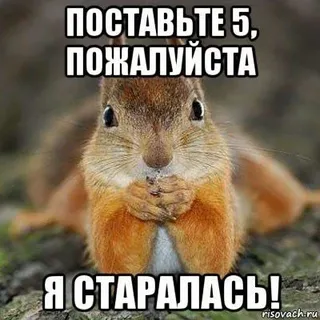